In [1]:
!pip install transformers

In [2]:
import torch

In [3]:
from transformers import BertForQuestionAnswering

# Load the pre-trained BERT model fine-tuned on SQuAD
model = BertForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [5]:
question = "What is the capital of France?"
context = "The capital of France is Paris."

In [7]:
input_ids = tokenizer.encode(question,context)
print("The input has a total of {:} tokens.".format(len(input_ids)))

The input has a total of 17 tokens.


Just to see exactly what the tokenizer is doing, let's print out the tokens with their IDs.

In [8]:
tokens = tokenizer.convert_ids_to_tokens(input_ids)
for token,id in zip(tokens,input_ids):
  if id== tokenizer.sep_token_id:
    print("")
  print("{:12s} {:>6}".format(token,id))
  if id== tokenizer.sep_token_id:
    print("")




[CLS]           101
what           2054
is             2003
the            1996
capital        3007
of             1997
france         2605
?              1029

[SEP]           102

the            1996
capital        3007
of             1997
france         2605
is             2003
paris          3000
.              1012

[SEP]           102



We've concatenated the question and answer_text together, but BERT still needs a way to distinguish them. BERT has two special "Segment" embeddings, one for segment "A" and one for segment "B". Before the word embeddings go into the BERT layers, the segment A embedding needs to be added to the question tokens, and the segment B embedding needs to be added to each of the answer_text tokens.

These additions are handled for us by the transformer library, and all we need to do is specify a '0' or '1' for each token.

In [9]:
sep_index = input_ids.index(tokenizer.sep_token_id)
num_sep_a = sep_index+1
num_sep_b = len(input_ids)-num_sep_a
segment_ids = [0]*num_sep_a + [1]*num_sep_b
assert len(segment_ids)== len(input_ids)

In [10]:
## Run our example through the model:
outputs = model(torch.tensor([input_ids]),
                             token_type_ids=torch.tensor([segment_ids]),
                             return_dict = True)
start_scores = outputs.start_logits
end_scores =  outputs.end_logits


Now we can highlight the answer just by looking at the most probable start and end words.

In [11]:
answer_start = torch.argmax(start_scores)
answer_end = torch.argmax(end_scores)
answer = " ".join(tokens[answer_start:answer_end+1])
print('Answer: "' + answer + '"')

Answer: "paris"


With a little more effort, we can reconstruct any words that got broken down into subwords.

In [12]:
answer = tokens[answer_start]
for i in range(answer_start + 1, answer_end + 1):
    if tokens[i][0:2] == "##":
        answer += tokens[i][2:]  # Append subword tokens (e.g., "##ing" -> "ing")
    else:
        answer += " " + tokens[i]  # Append full words with a space

# Print the final answer
print('Answer: "' + answer + '"')


Answer: "paris"


# **Visualizing Scores**
I was curious to see what the scores were for all of the words. The following cells generate bar plots showing the start and end scores for every word in the input

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")
plt.rcParams["figure.figsize"]=[12,6]


Retrieve all of the start and end scores, and use all of the tokens as x-axis labels.

In [14]:
import numpy as np

# Pull the scores out of PyTorch Tensors and convert them to 1D numpy arrays.
start_scores = start_scores.detach().numpy().flatten()
end_scores = end_scores.detach().numpy().flatten()

# Assuming `tokens` is a list of tokens
token_labels = []
for token in tokens:
    token_labels.append(token)

Create a bar plot showing the score for every input word being the "start" word.

<ipython-input-15-6ac051f7141d>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x = token_labels,y = start_scores,ci=None)
<ipython-input-15-6ac051f7141d>:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")


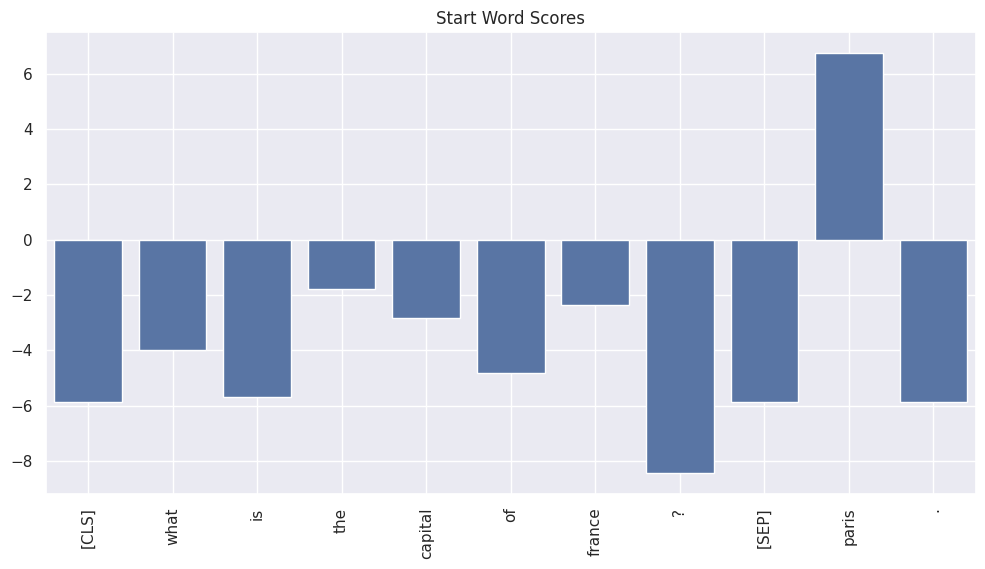

In [15]:
# Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x = token_labels,y = start_scores,ci=None)
## turn the x labels vertical:
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
ax.grid(True)
plt.title("Start Word Scores")
plt.show()


Create a second bar plot showing the score for every input word being the "end" word.

<ipython-input-16-c4b44a550470>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x = token_labels,y = end_scores,ci=None)
<ipython-input-16-c4b44a550470>:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")


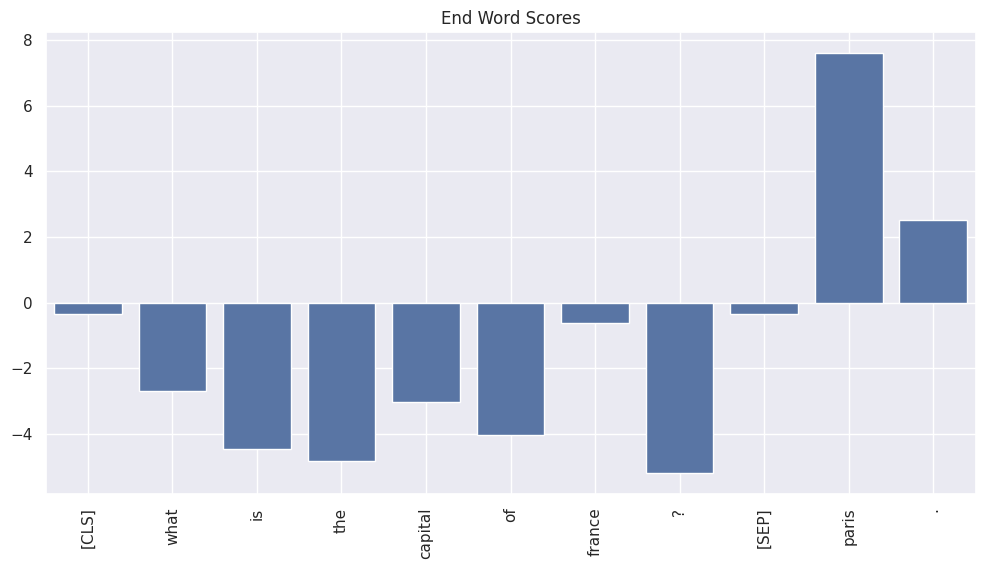

In [16]:
# Create a barplot showing the end word score for all of the tokens.
ax = sns.barplot(x = token_labels,y = end_scores,ci=None)
## turn the x labels vertical:
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
ax.grid(True)
plt.title("End Word Scores")
plt.show()

Alternate View

I also tried visualizing both the start and end scores on a single bar plot, but I think it may actually be more confusing then seeing them separately.

In [17]:
import pandas as pd
# Store the tokens and scores in a DataFrame.
# Each token will have two rows, one for its start score and one for its end
# score. The "marker" column will differentiate them. A little wacky, I know.
scores = []
for(i, token_label) in enumerate(token_labels):
    scores.append((token_label, start_scores[i], "start"))
    scores.append((token_label, end_scores[i], "end"))
df = pd.DataFrame(scores, columns=["token", "score", "marker"])

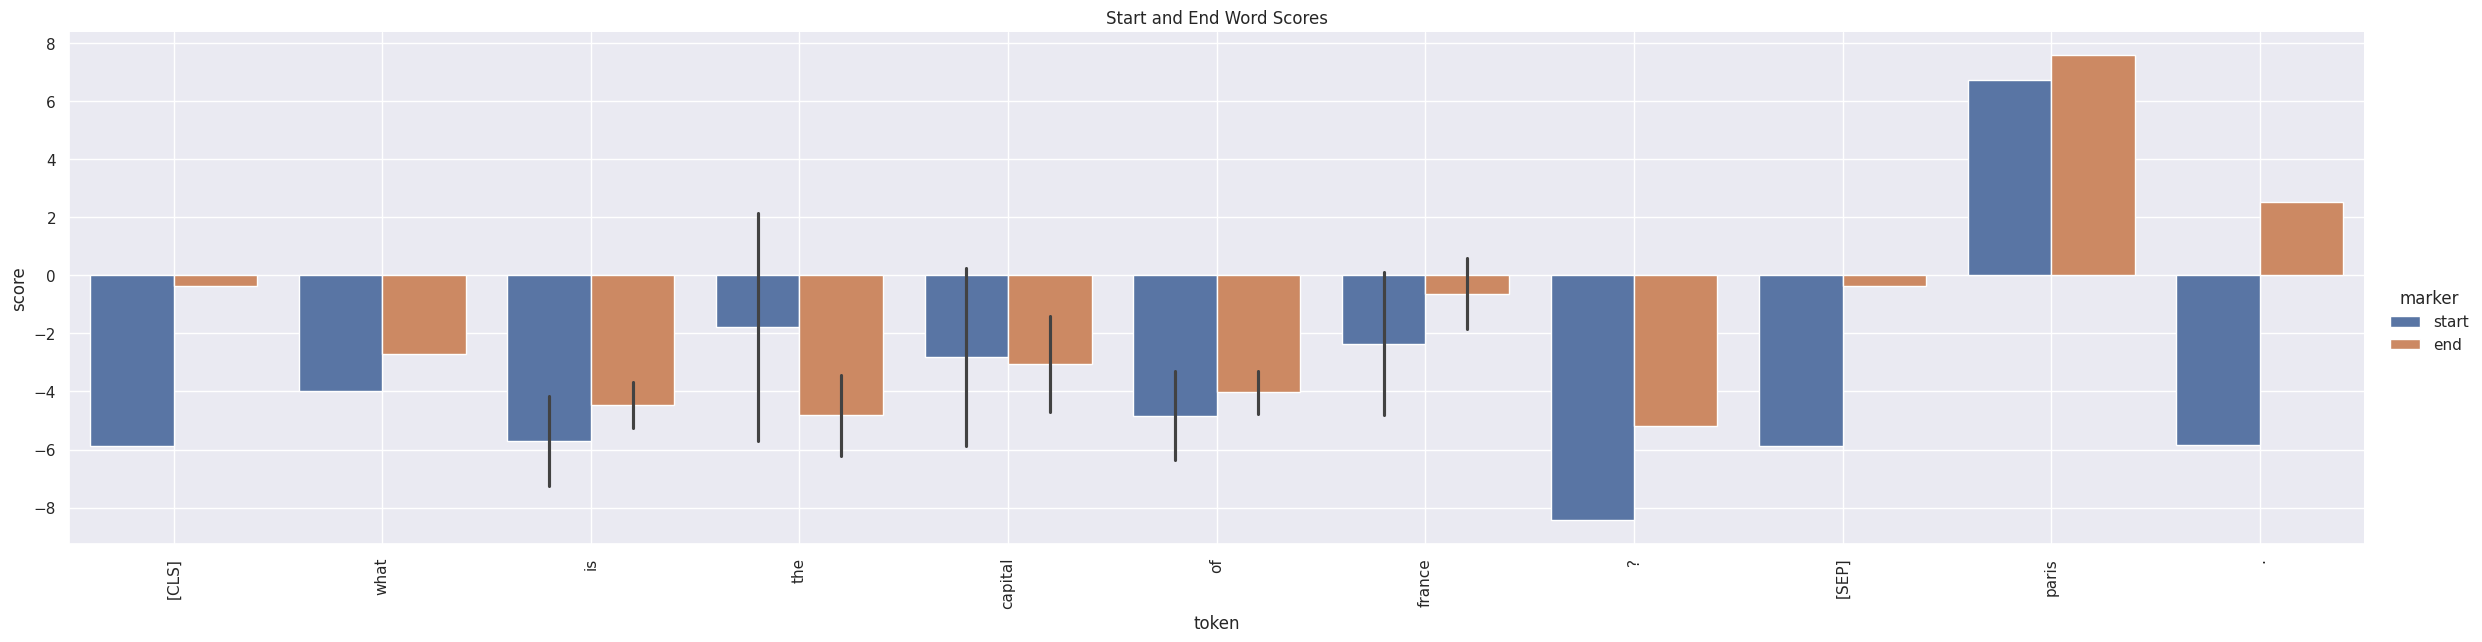

In [18]:
g = sns.catplot(data=df,x="token",y= "score",hue="marker",kind="bar",height=6,aspect=4)
g.set_xticklabels(g.ax.get_xticklabels(), rotation=90, ha="center")
g.ax.grid(True)
plt.title("Start and End Word Scores")
plt.show()


As our reference text, I've taken the Abstract of the BERT paper.

In [19]:
import  textwrap
wrapper = textwrap.TextWrapper(width=80)
bert_abstract = """
We introduce a new language representation model called BERT, which stands for
Bidirectional Encoder Representations from Transformers. Unlike recent language
representation models, BERT is designed to pre-train deep bidirectional
representations from unlabeled text by jointly conditioning on both left and
right context."""

In [20]:
wrapped_text = wrapper.fill(bert_abstract.replace("\n", " "))
print(wrapped_text)

 We introduce a new language representation model called BERT, which stands for
Bidirectional Encoder Representations from Transformers. Unlike recent language
representation models, BERT is designed to pre-train deep bidirectional
representations from unlabeled text by jointly conditioning on both left and
right context.


In [21]:
def answer_question(question, answer_text):
  input_ids = tokenizer.encode(question,answer_text)
  print("Query has {:,} tokens.\n".format(len(input_ids)))
  sep_index = input_ids.index(tokenizer.sep_token_id)
  num_seg_a = sep_index+1
  num_seg_b = len(input_ids)-num_seg_a
  segment_ids = [0]*num_seg_a+[1]*num_seg_b
  assert len(segment_ids)==len(input_ids)
  outputs = model(torch.tensor([input_ids]),token_type_ids=torch.tensor([segment_ids]),return_dict= True)
  start_scores = outputs.start_logits
  end_scores  = outputs.end_logits
  answer_start = torch.argmax(start_scores)
  answer_end = torch.argmax(end_scores)
  tokens = tokenizer.convert_ids_to_tokens(input_ids)
  answer = tokens[answer_start]
  for i in range(answer_start+1,answer_end+1):
    if tokens[i][0:2] == "##":
      answer += tokens[i][2:]
    else:
      answer += " " + tokens[i]
  print('Answer: "' + answer + '"')

In [22]:
question = "What does the 'B' in BERT stand for?"

answer_question(question, bert_abstract)

Query has 73 tokens.

Answer: "bidirectional encoder representations from transformers"
